# Preliminary Analysis

An initial objective will be to verify that the causal relation between exchange flows from main crypto markets and price returns (for BTC and ETH) holds also for the dataset that we are going to use (which includes more recent data than previous studies on the topic).
* Exploratory analysis of the dataset: summary statistics for each feature across exchanges and for both currencies, Jarque-Bera normality test and Augmented dickey Fuller stationarity test, correlation analysis (+ commentary on the results found)
* Linear regression analysis between features with different lags and across exchanges
* Granger-causality between features and across exchanges

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Summary Statistics

RET: daily log return <br>
VOL: daily trading volume <br>
NET: daily net flow (inflow minus outflow) <br>
9 exchanges: Binance, Bitfinex, Bitmex, Bitstamp, Bittrex, Huobi, Kraken, Kucoin, and Poloniex

In [2]:
## import raw data
btc_d = pd.read_csv('data/btc_daily_data.csv')
eth_d = pd.read_csv('data/eth_daily_data.csv')

In [3]:
## clean Bitcoin data 
exch = ['binance', 'bitfinex', 'bitmex', 'bitstamp', 'bittrex', 'gemini', 'huobi', 'kraken', 'poloniex']
btc = pd.DataFrame(index=btc_d['date']) 
# RET: daily return
btc['RET'] = np.log(btc_d['close']/btc_d['close'].shift(1)).tolist() # daily log return
# VOL: daily trading volume
btc['VOL'] = btc_d['volume'].tolist()
# NET: daily net flow
for exchange in exch:
    btc['NET.{}'.format(exchange)]=(btc_d['exch.{}.flow.in.ntv'.format(exchange)]-
                                    btc_d['exch.{}.flow.out.ntv'.format(exchange)]).tolist()

display(btc.head())

,RET,VOL,NET.binance,NET.bitfinex,NET.bitmex,NET.bitstamp,NET.bittrex,NET.gemini,NET.huobi,NET.kraken,NET.poloniex
date,,,,,,,,,,,
2016-06-30,NaN,148920.0,0.0,-2059.973067,99.331971,-2593.080092,-125.948094,206.048336,-2375.033630,2024.025567,-2778.125983
2016-07-01,0.006768,100240.0,0.0,4240.004996,92.550998,1251.658664,168.334678,-105.925147,-2268.096642,-928.878199,613.166590
2016-07-02,0.034230,177630.0,0.0,-3811.891401,-25.376020,-597.836889,9.495110,-44.394717,-9159.634110,672.465411,-1075.431292
2016-07-03,-0.053583,65100.0,0.0,5237.602833,-2.565174,647.374927,88.733722,402.367398,-9530.151435,-416.704041,23.876708
2016-07-04,0.020228,67140.0,0.0,288.595371,-22.923171,545.125563,145.272407,185.619464,3390.126196,3161.476927,679.750955


In [4]:
## clean Ethereum data
exch = ['binance', 'bitfinex', 'bitstamp', 'bittrex', 'gemini', 'kraken', 'poloniex'] # no data for bitmex and huobi
eth = pd.DataFrame(index=eth_d['date']) 
eth['RET'] = np.log(eth_d['close']/eth_d['close'].shift(1)).tolist() # daily log return
eth['VOL'] = eth_d['volume'].tolist()
for exchange in exch:
    eth['NET.{}'.format(exchange)]=(eth_d['exch.{}.flow.in.ntv'.format(exchange)]-
                                    eth_d['exch.{}.flow.out.ntv'.format(exchange)]).tolist()
display(eth.head())

,RET,VOL,NET.binance,NET.bitfinex,NET.bitstamp,NET.bittrex,NET.gemini,NET.kraken,NET.poloniex
date,,,,,,,,,
2016-06-30,NaN,968940.0,0.0,4357.847025,0.0,4745.345643,9718.900192,34368.279174,31486.711303
2016-07-01,-0.008903,1250000.0,0.0,420.873548,0.0,5347.637741,-4673.071735,17816.258406,5347.576758
2016-07-02,-0.015568,1890000.0,0.0,23169.410924,0.0,3684.385453,-2414.242300,-7351.123703,11283.902563
2016-07-03,-0.031030,786940.0,0.0,-7909.724666,0.0,-3312.355331,-7902.002866,-3797.682825,11648.982746
2016-07-04,-0.031144,907110.0,0.0,1271.289529,0.0,1014.503037,590.383059,398444.262380,63597.078794


In [5]:
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller

def stylizedfacts(ts):
    ts = ts.dropna() 
    ts = ts[ts != 0]
    Mean = ts.mean()
    Std = ts.std()
    Min = ts.min()
    Median = ts.median()
    Max = ts.max()
    JB = round(jarque_bera(ts).statistic,4)
    JB_pval = jarque_bera(ts).pvalue
    if JB_pval <= 0.01:
        JB = f'{JB}***'
    elif 0.01 < JB_pval <= 0.05:
        JB = f'{JB}**'
    elif 0.05 < JB_pval <= 0.1:
        JB = f'{JB}*'
    adf = round(adfuller(ts)[0],4)
    adf_pval = adfuller(ts)[1]
    if adf_pval <= 0.01:
        adf = f'{adf}***'
    elif 0.01 < adf_pval <= 0.05:
        adf = f'{adf}**'
    elif 0.05 < adf_pval <= 0.1:
        adf = f'{adf}*'
    output = pd.Series([Mean, Std, Min, Median, Max, JB, adf])
    return output

In [6]:
multindex = [
    np.array(["BTC"]*btc.shape[1] + ["ETH"]*eth.shape[1]),
    np.array(btc.columns.tolist() + eth.columns.tolist()),
]
stat = pd.DataFrame(index=multindex, columns=['Mean', 'Std', 'Min', 'Median', 'Max', 'JB', 'ADF']) 

for col in btc.columns:
    stat.loc[('BTC',col)] = stylizedfacts(btc[col]).tolist()
    
for col in eth.columns:
    stat.loc[('ETH',col)] = stylizedfacts(eth[col]).tolist()

display(stat)

Mean             Std             Min       Median  \
BTC RET                 0.002207        0.042019       -0.479934      0.00218   
    VOL            585677.256065  1397859.647552          2400.0     180670.0   
    NET.binance       277.129008     2865.642278   -27245.169933   135.719422   
    NET.bitfinex     -130.496513     6108.728426  -121054.090457    30.834436   
    NET.bitmex         56.213694      1889.04744   -34096.929705    51.858614   
    NET.bitstamp     -262.611975     2172.255358   -30531.728449  -153.417498   
    NET.bittrex       -64.889362     1575.058929   -11265.461988   -59.163814   
    NET.gemini         53.241906     2112.491507   -16424.057375    19.786539   
    NET.huobi         -38.455199     2516.984113   -26518.490634     40.50666   
    NET.kraken       -281.191593     3092.109855   -40168.725188  -100.529798   
    NET.poloniex      -48.731764     1754.121295   -19364.006567    -57.99326   
ETH RET                 0.002826        0.057639       -0.569507     0.000926   
    VOL           6039636.555256  8103349.085864          7610.0    2280000.0   
    NET.binance      2499.962054    51968.802486   -539884.30289   141.228885   
    NET.bitfinex     -315.998976    70364.866534  -995304.971652   376.732092   
    NET.bitstamp      414.195889    12537.012075  -201171.103685   239.789587   
    NET.bittrex       431.825197    10825.815083  -163193.049145    -253.2652   
    NET.gemini        547.595656    25297.449481  -231237.108676   -61.136853   
    NET.kraken      -2992.271849    35873.495218  -744418.305422 -2417.488645   
    NET.poloniex     -4075.30423    76326.130267 -1224401.233088 -1238.442795   

                             Max               JB          ADF  
BTC RET                 0.227618    11056.5197***  -29.7557***  
    VOL               20260000.0   302236.4974***   -7.7187***  
    NET.binance     26273.320001    28389.4954***   -8.0798***  
    NET.bitfinex     32536.40393   4188060.707***  -12.8943***  
    NET.bitmex      25151.010367   657443.9981***  -13.0256***  
    NET.bitstamp    14668.299449    154786.592***  -43.0446***  
    NET.bittrex     19345.994173    49811.1038***   -6.6744***  
    NET.gemini      32811.067196   180307.8894***   -7.7879***  
    NET.huobi       25256.626211    40711.2751***  -13.1328***  
    NET.kraken      38112.388789   201193.5622***  -10.2889***  
    NET.poloniex    13766.676194    31866.4199***   -8.9558***  
ETH RET                 0.260244     5242.9865***   -12.549***  
    VOL               77470000.0    12832.7224***    -3.2237**  
    NET.binance    424515.823542    53119.7266***  -16.9306***  
    NET.bitfinex   575011.437727   288043.0355***  -14.5602***  
    NET.bitstamp    80055.821536     265372.44***  -10.1146***  
    NET.bittrex     94608.848902   162973.1712***  -10.8251***  
    NET.gemini     285607.359589    99628.6224***   -8.2742***  
    NET.kraken      398444.26238  1205400.7237***   -6.5289***  
    NET.poloniex  1553929.089877  2169588.5531***  -13.7698***

The symbols \*, \*\*, and \*\*\* denote the rejection of the null hypothesis (normal and unit root/non-stationary) at the 10%, 5%, and 1% significance levels.

In [ ]:
print(stat.to_latex(index=True))  

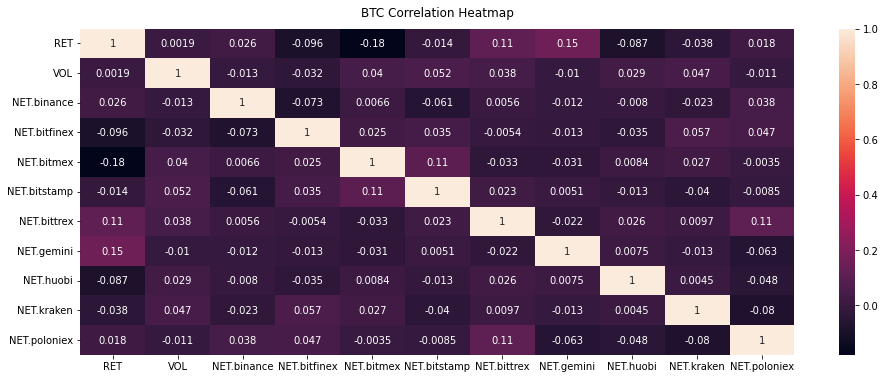

In [7]:
plt.figure(figsize=(16, 6))
btc_corr = sns.heatmap(btc[(btc!=0).all(1)].dropna().corr(), annot=True).set_title('BTC Correlation Heatmap', 
                                                                                    fontdict={'fontsize':12}, pad=12)
plt.show()

In [ ]:
btc_corr.figure.savefig("btc_corr.png")

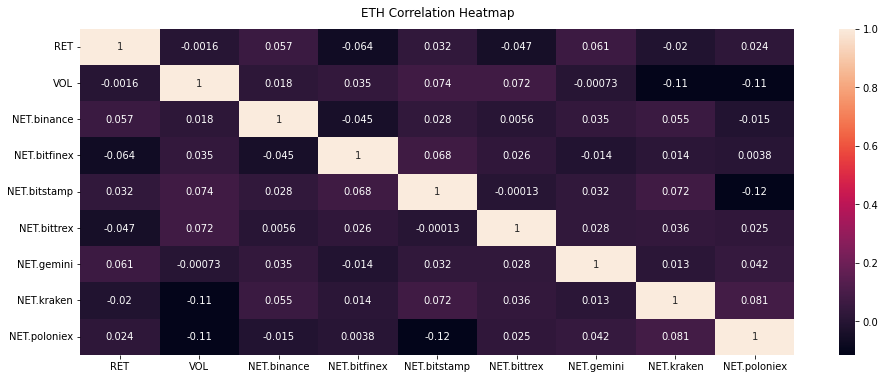

In [8]:
plt.figure(figsize=(16, 6))
eth_corr = sns.heatmap(eth[(eth!=0).all(1)].dropna().corr(), annot=True).set_title('ETH Correlation Heatmap', 
                                                                                    fontdict={'fontsize':12}, pad=12)
plt.show()

In [ ]:
eth_corr.figure.savefig("eth_corr.png")

## 2. Vector Autoregression (VAR)

VAR between return and net flow among the exchanges <br>

$$ \text{VAR(3):  } Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \phi_3 Y_{t-3} + \epsilon_t $$
L1 - one lag 

In [9]:
from statsmodels.tsa.api import VAR

In [10]:
btc_data = btc[(btc!=0).all(1)].dropna()
model = VAR(btc_data)
results = model.fit(3) # order: 3 lags
param = round(results.params,4)
pval = results.pvalues

/Users/wexu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [11]:
btc_VAR_res = pd.DataFrame(index=param.index, columns=param.columns)
for col in param.columns:
    for row in param.index:
        if pval[col].loc[row] <= 0.01:
            btc_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}***'
        elif 0.01 < pval[col].loc[row] <= 0.05:
            btc_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}**'
        elif 0.05 < pval[col].loc[row] <= 0.1:
            btc_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}*'
        else:
            btc_VAR_res[col].loc[row] = param[col].loc[row]
btc_VAR_res = btc_VAR_res.drop(index='const')
display(btc_VAR_res)

,RET,VOL,NET.binance,NET.bitfinex,NET.bitmex,NET.bitstamp,NET.bittrex,NET.gemini,NET.huobi,NET.kraken,NET.poloniex
L1.RET,-0.0618**,-51755.2589,3264.9283*,-5007.5883**,-141.9644,1598.0887,-1827.4775*,4295.6048***,2739.6826**,-1128.7883,-276.8568
L1.VOL,0.0,0.6397***,0.0001,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
L1.NET.binance,-0.0,-3.5123,0.0714***,-0.0389,-0.028,-0.0138,0.0209,0.0039,0.04*,-0.0094,0.018
L1.NET.bitfinex,-0.0,-1.7189,0.0211,0.0659**,0.0566***,0.0088,0.0333***,0.012,0.006,0.0243,0.0248***
L1.NET.bitmex,0.0,2.1987,0.016,0.051,0.2018***,0.0629**,0.0096,0.0626**,-0.0465,-0.0078,-0.0074
L1.NET.bitstamp,-0.0,0.2492,-0.0013,-0.0085,0.0346,0.0299,-0.0361*,0.0313,0.0446*,-0.177***,0.0084
L1.NET.bittrex,0.0,-0.2166,0.1187***,-0.0244,-0.0477,-0.0084,0.2036***,-0.0226,-0.0716**,0.0374,0.0143
L1.NET.gemini,-0.0**,-0.6369,-0.0107,-0.0362,0.0269,0.0045,-0.0314,-0.0027,0.0386,0.0485,0.0181
L1.NET.huobi,-0.0*,3.8141,-0.0171,0.0353,-0.0061,0.0217,0.0215,0.004,0.2448***,0.0813**,-0.0186
L1.NET.kraken,-0.0,3.9274,-0.0057,0.0092,-0.0278,-0.0536***,0.0008,-0.0339*,0.054***,0.1248***,0.0396***


The symbols \*, \*\*, and \*\*\* denote the statistical significance at the 10%, 5%, and 1% levels

In [ ]:
print(btc_VAR_res.to_latex(index=True))  

In [12]:
eth_data = eth[(eth!=0).all(1)].dropna()
model = VAR(eth_data)
results = model.fit(3) # order: 3 lags
param = round(results.params,4)
pval = results.pvalues

/Users/wexu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [13]:
eth_VAR_res = pd.DataFrame(index=param.index, columns=param.columns)
for col in param.columns:
    for row in param.index:
        if pval[col].loc[row] <= 0.01:
            eth_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}***'
        elif 0.01 < pval[col].loc[row] <= 0.05:
            eth_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}**'
        elif 0.05 < pval[col].loc[row] <= 0.1:
            eth_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}*'
        else:
            eth_VAR_res[col].loc[row] = param[col].loc[row]
eth_VAR_res = eth_VAR_res.drop(index='const')
display(eth_VAR_res)

,RET,VOL,NET.binance,NET.bitfinex,NET.bitstamp,NET.bittrex,NET.gemini,NET.kraken,NET.poloniex
L1.RET,-0.0727***,597518.3399,46938.9583*,-93761.4177***,6205.8914,-4560.0646,19127.78*,-12505.9957*,-12221.8822**
L1.VOL,-0.0,0.799***,0.0003,0.0003,0.0,0.0002***,0.0,-0.0,-0.0
L1.NET.binance,-0.0,1.8787,-0.0601**,-0.0255,0.0115*,0.0024,0.0022,-0.0002,-0.009*
L1.NET.bitfinex,0.0**,1.4307,-0.0086,0.1786***,0.0049,-0.0074,-0.0142,0.004,-0.0037
L1.NET.bitstamp,0.0,0.1534,0.1151,-0.0075,-0.0388,-0.0003,0.056,-0.0109,0.0809***
L1.NET.bittrex,-0.0,10.3739,0.213*,-0.0318,-0.0186,0.2241***,-0.014,0.0097,-0.0427*
L1.NET.gemini,-0.0,-1.4211,-0.0383,-0.0434,-0.0083,-0.0154,-0.0317,0.0335*,0.0096
L1.NET.kraken,-0.0,-6.0707,0.095,-0.0744,0.0524**,0.0246,0.0223,0.1762***,0.0635***
L1.NET.poloniex,0.0,7.6378,0.0323,-0.1913,0.0282,-0.0178,-0.0599,0.1156***,0.0439*
L2.RET,0.0911***,-2240694.4451,-87.0269,-34968.6041,3664.5715,-6185.0609,23059.6114**,-7567.3849,-10823.6172**


In [ ]:
print(eth_VAR_res.to_latex(index=True))  

## 3. Granger’s Causality

1. return and net flow
2. return and volume

In [14]:
from statsmodels.tsa.stattools import grangercausalitytests

**null hypothesis: Granger non causality** (time series in the second column does NOT Granger cause the time series in the first column) <br>
4 tests: params_ftest, ssr_ftest (based on F distribution); ssr_chi2test, lrtest (based on chi-square distribution)

In [15]:
def grangers_causality_pval(data,lag):
    res = pd.DataFrame(index=data.columns, columns=data.columns)
    test_list = ['ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest']
    for col in res.columns:
        for row in res.index:
            result = grangercausalitytests(data[[col, row]], # whether row variable granger cause column variable
                                         maxlag=lag, verbose=False) 
            # result[lag][0-summary][test][0-statistics,1-pval,2-DOF]
            minpval = np.min([np.min([round(result[i+1][0][test][1],6) for i in range(lag)]) # min pval of each test
                              for test in test_list]) # min pvalue of all test
            if minpval <= 0.01:
                res.loc[row,col] = f'{minpval}***' 
            elif 0.01 < minpval <= 0.05:
                res.loc[row,col] = f'{minpval}**' 
            elif 0.05 < minpval <= 0.1:
                res.loc[row,col] = f'{minpval}*' 
            else:
                res.loc[row,col] = minpval
            if row == col:
                res.loc[row,col] = '-'
    return res

In [16]:
btc_GC_res = grangers_causality_pval(btc_data,3)
display(btc_GC_res)

,RET,VOL,NET.binance,NET.bitfinex,NET.bitmex,NET.bitstamp,NET.bittrex,NET.gemini,NET.huobi,NET.kraken,NET.poloniex
RET,-,0.885425,0.043523**,0.001891***,0.645069,0.447772,0.003122***,0.0***,0.017457**,0.305457,0.139251
VOL,0.738179,-,0.645405,0.338368,0.145338,0.033997**,0.086896*,0.782383,0.363928,0.085273*,0.745888
NET.binance,0.373462,0.555179,-,0.116155,0.070047*,0.571515,0.246298,0.499973,0.172033,0.770107,0.14078
NET.bitfinex,0.099248*,0.387973,0.398871,-,8.5e-05***,0.585352,0.000682***,0.979828,0.799817,0.254785,0.00297***
NET.bitmex,0.534624,0.53498,0.936784,0.071771*,-,0.020908**,0.248235,0.034754**,0.095157*,0.790159,0.522236
NET.bitstamp,0.186612,0.029227**,0.939082,0.61908,0.064108*,-,0.118516,0.067819*,0.154341,0.0***,0.0***
NET.bittrex,0.141204,0.331912,0.004263***,0.073674*,0.106123,0.121934,-,0.206901,0.145839,0.223875,0.04394**
NET.gemini,0.009633***,0.830684,0.149061,0.114942,0.294047,0.889751,0.027772**,-,0.03643**,0.052492*,0.188848
NET.huobi,0.044543**,0.49495,0.468233,0.224634,0.712853,0.203409,0.043003**,0.876665,-,0.00375***,0.080484*
NET.kraken,0.807767,0.418185,0.724765,0.24155,0.211088,0.000136***,0.432591,0.002643***,0.002305***,-,0.0***


Note: the asterisk sign shows the row variable Granger cause the column variable (dependent variable). <br> \*, \*\*, and \*\*\* denote significance at the 10%, 5%, and 1% levels respectively.

In [ ]:
print(btc_GC_res.to_latex(index=True))  

In [17]:
eth_GC_res = grangers_causality_pval(eth_data,3)
display(eth_GC_res)

,RET,VOL,NET.binance,NET.bitfinex,NET.bitstamp,NET.bittrex,NET.gemini,NET.kraken,NET.poloniex
RET,-,0.288862,0.045691**,0.001059***,0.143768,0.521374,0.008306***,0.088575*,0.001298***
VOL,0.935213,-,0.655863,0.298275,0.007916***,0.007483***,0.888719,0.000605***,0.000119***
NET.binance,0.029882**,0.573791,-,0.156164,0.030625**,0.511574,0.217844,0.822465,0.112244
NET.bitfinex,0.05643*,0.30204,0.166462,-,0.001244***,0.07019*,0.044005**,0.026044**,0.725011
NET.bitstamp,0.003574***,0.23339,0.039855**,0.015595**,-,0.001806***,0.075816*,0.297341,3.4e-05***
NET.bittrex,0.560097,0.313586,0.085321*,0.30527,0.153731,-,0.629702,0.616164,0.025474**
NET.gemini,0.058853*,0.738486,0.311167,0.265245,0.500695,0.207928,-,0.065767*,0.720487
NET.kraken,0.047222**,0.119316,0.401056,0.222202,0.001114***,0.355309,0.460407,-,1e-06***
NET.poloniex,0.46369,0.447621,0.753802,0.417841,0.537024,0.342321,0.120426,0.000264***,-


In [ ]:
print(eth_GC_res.to_latex(index=True))  